# Drop-Wave Function

The Drop-Wave function is a complex 2-dimensional function with ripples expanding across it. It has a single global minimum and multiple local minima, making it a challenging optimization problem. 

It's mathematical formulation is given as $$f(\textbf{x}) = -\frac{1 + \cos(12\sqrt(x_1^2+x_2^2))}{0.5(x_1^2+x_2^2)+2}$$

## Input Domain

The Drop-Wave function is typically evaluated on the square $x_i \in [-5.12,5.12], \forall i=1,2.$

## Global Minimum

There is only one global minimum, $f(\textbf{x}^*)=-1$, located at $\textbf{x}^*=(0,0).$

## Visualization of the Function

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Objective function
def drop_wave(x1, x2):
    return -(
        (1 + np.cos(12 * (x1**2 + x2**2) ** 0.5)) / (0.5 * (x1**2 + x2**2) + 2)
    )


print(drop_wave(0, 0))

-1.0


Text(0.5, 0.92, 'Drop-Wave Surface Plot')

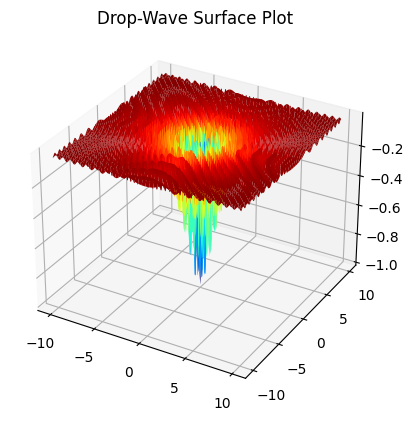

In [39]:
# Plot Drop-Wave in 3D
r_min, r_max = -10, 10
x_axis = y_axis = np.arange(r_min, r_max, 0.05)
x1, x2 = np.meshgrid(x_axis, y_axis)
f = drop_wave(x1, x2)

figure = plt.figure()
axis = figure.add_subplot(111, projection="3d")
axis.plot_surface(x1, x2, f, cmap="jet", shade="false")

# Set the title
axis.set_title("Drop-Wave Surface Plot")

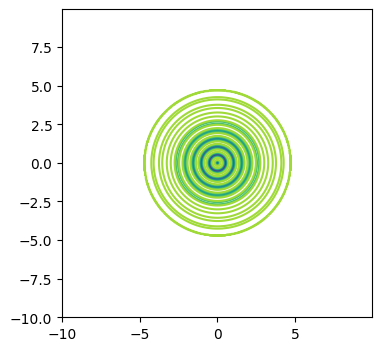

In [40]:
# Contour Plot
figure = plt.figure(figsize=(4, 4))
plt.contour(x1, x2, f)

## DeepLifting Solution

In [41]:
# imports
import time
import sys
import math

# Adding PyGRANSO directories. Should be modified by user
sys.path.append("/home/seanschweiger/dl_testing/Deeplifting")

import torch
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from deeplifting.models import DeepliftingMLP

In [42]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def drop_wave(x1, x2):
    return -(
        (1 + torch.cos(12 * (x1**2 + x2**2) ** 0.5))
        / (0.5 * (x1**2 + x2**2) + 2)
    )


def user_fn(model, inputs):
    output = model(inputs=None)
    x1, x2 = output

    # Can map x1 and x2 to [0,1]
    # and shift interval to accomplish
    # same thing as constraints
    x1 = torch.sigmoid(x1) * (-5.12 - 5.12) + 5.12
    x2 = torch.sigmoid(x2) * (-5.12 - 5.12) + 5.12

    # Objective fn.
    f = drop_wave(x1, x2)

    # Inequality constraint
    ci = None

    # Equality constraint
    ce = None

    return [f, ci, ce]

In [43]:
# Build model
model = DeepliftingMLP(input_size=50, layer_sizes=(128, 256, 256, 128), output_size=2)
model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())
print(nvar)

139498


In [44]:
torch.manual_seed(1)

opts = pygransoStruct()

x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 10
opts.limited_mem_size = 100
opts.stat_l2_model = False
opts.double_precision = True
opts.viol_ineq_tol = 1e-8
opts.opt_tol = 1e-8

points = []
comb_fn = lambda model: user_fn(model, points)

# Run the main algorithm
start = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end = time.time()

print(f"Starting point for this problem = {x0}\n")
print(f"Total Wall Time: {end-start}\n")
print(soln.final.f)



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

## PyGRANSO Solution

### Function Setup

In [45]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input variables
var_in = {'x1': [1], 'x2': [1]}


def comb_fn(X_struct):
    x1 = X_struct.x1
    x2 = X_struct.x2

    # objective function
    f = -(
        (1 + torch.cos(12 * (x1**2 + x2**2) ** 0.5))
        / (0.5 * (x1**2 + x2**2) + 2)
    )

    # inequality constraint
    ci = pygransoStruct()
    ci.c1 = -x1 - 5.12
    ci.c2 = x1 - 5.12
    ci.c3 = -x2 - 5.12
    ci.c4 = x2 - 5.12

    # equality constraint
    ce = None

    return [f, ci, ce]

### Main Algorithm

In [46]:
# run 10 trials with different random starting points
for i in range(10):
    np.random.seed(i)
    opts = pygransoStruct()
    # initialize starting vector with random values in [-10,10]
    opts.x0 = torch.rand(size=(2, 1), device=device, dtype=torch.double) * 20 - 10
    opts.torch_device = device
    start = time.time()
    soln = pygranso(var_spec=var_in, combined_fn=comb_fn, user_opts=opts)
    end = time.time()
    print("Total Wall Time: {}s".format(end - start))
    print(soln.final.x, soln.final.f)



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

## IPOPT Solution

In [47]:
# import statements
import numpy as np
from cyipopt import minimize_ipopt


# Objective function
def objective(x):
    return -(
        (1 + np.cos(12 * (x[0] ** 2 + x[1] ** 2) ** 0.5))
        / (0.5 * (x[0] ** 2 + x[1] ** 2) + 2)
    )


for i in range(10):
    np.random.seed(i)
    # initialize starting vector with random values in [-5.12,5.12]
    x0 = np.random.rand(2) * 10.24 - 5.12

    result = minimize_ipopt(objective, x0)
    print(f"Trial {i+1}")
    print("Optimal x* found: ", result.x)
    print("Minimum value found: ", objective(result.x))

Trial 1
Optimal x* found:  [0.23042254 1.01570103]
Minimum value found:  -0.7857513346523575
Trial 2
Optimal x* found:  [-1.10504279  2.93410573]
Minimum value found:  -0.2888120051180351
Trial 3
Optimal x* found:  [-0.55972439 -4.14577359]
Minimum value found:  -0.1858447617036594
Trial 4
Optimal x* found:  [-0.12332557 -0.50538603]
Minimum value found:  -0.9362453278079409
Trial 5
Optimal x* found:  [4.68350154 0.47365777]
Minimum value found:  -0.15277048103661173
Trial 6
Optimal x* found:  [-2.82416046  3.7661195 ]
Minimum value found:  -0.15277048103661173
Trial 7
Optimal x* found:  [ 3.36455163 -1.43896717]
Minimum value found:  -0.22972368470054755
Trial 8
Optimal x* found:  [-4.36480265  2.88367569]
Minimum value found:  -0.12742374573158638
Trial 9
Optimal x* found:  [5.21950427 6.54889816]
Minimum value found:  -0.053939199314084835
Trial 10
Optimal x* found:  [-5.23131788  0.02002872]
Minimum value found:  -0.12742374573158685


## Simulated Annealing Solution

In [48]:
import numpy as np
from scipy.optimize import dual_annealing


# Objective fn.
def drop_wave(x):
    return -(
        (1 + np.cos(12 * (x[0] ** 2 + x[1] ** 2) ** 0.5))
        / (0.5 * (x[0] ** 2 + x[1] ** 2) + 2)
    )


bounds = [(-5.12, 5.12), (-5.12, 5.12)]

# Run 10 trials
results = []
for i in range(10):
    result = dual_annealing(drop_wave, bounds)
    results.append(result)

print("Simulated Annealing Results")
for i, res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")

Simulated Annealing Results
Trial 1
x: [ 0.25838201 -0.45151173], f(x): -0.9362453278074611

Trial 2
x: [8.38450186e-08 5.08288635e-08], f(x): -0.9999999999996514

Trial 3
x: [-5.19555244e-09 -5.19409859e-09], f(x): -0.999999999999998

Trial 4
x: [-4.96703282e-09 -5.25782346e-09], f(x): -0.9999999999999981

Trial 5
x: [-3.78107764e-09 -2.49191002e-10], f(x): -0.9999999999999996

Trial 6
x: [ 1.64927685e-08 -1.54737318e-08], f(x): -0.9999999999999813

Trial 7
x: [-4.84520647e-09 -4.93880569e-09], f(x): -0.9999999999999982

Trial 8
x: [-4.95525749e-09 -4.98997647e-09], f(x): -0.9999999999999982

Trial 9
x: [-1.43686130e-08 -4.21702857e-08], f(x): -0.9999999999999281

Trial 10
x: [-0.39305345 -0.34078324], f(x): -0.936245327807939



## Differential Evolution

In [49]:
import numpy as np
from scipy.optimize import differential_evolution


# Objective fn.
def drop_wave(x):
    return -(
        (1 + np.cos(12 * (x[0] ** 2 + x[1] ** 2) ** 0.5))
        / (0.5 * (x[0] ** 2 + x[1] ** 2) + 2)
    )


bounds = [(-5.12, 5.12), (-5.12, 5.12)]

# Run 10 trials
results = []
for i in range(10):
    result = differential_evolution(drop_wave, bounds)
    results.append(result)

print("Differential Evolution Results")
for i, res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")

Differential Evolution Results
Trial 1
x: [1.91830389e-08 3.08783968e-08], f(x): -0.9999999999999523

Trial 2
x: [-4.94713353e-09 -5.16357431e-09], f(x): -0.9999999999999982

Trial 3
x: [-0.51561884 -0.06900324], f(x): -0.936245327807941

Trial 4
x: [ 0.06860705 -0.51567182], f(x): -0.9362453278074698

Trial 5
x: [-4.63989680e-09 -4.19024649e-09], f(x): -0.9999999999999987

Trial 6
x: [-1.28117564e-08  3.93768132e-08], f(x): -0.9999999999999378

Trial 7
x: [-5.12711065e-09 -4.99154800e-09], f(x): -0.9999999999999982

Trial 8
x: [-0.51919558 -0.03256036], f(x): -0.936245327807941

Trial 9
x: [-3.41563907e-09  4.36034880e-08], f(x): -0.9999999999999307

Trial 10
x: [-1.95003819e-09 -1.46681962e-09], f(x): -0.9999999999999998

